- 0 Choose a time period during the winter that you like.
- 1a Make measurements of x (displacement) every 15 min, for 4 hours. This generates 16 estimates of x.
- 1b Calculate the mean, <x>.
- 1c Calculate the standard deviation, sigma.
- 1d Calculate the standard error, delta.
- 2 Repeat 1a-1b, for a period of 5 days.
- 3 Plot a histogram of the values <x> that you generate in this way; there will be 30 values (6 per day for each of 5 days). Calculate the standard deviation of these mean values. We want to compare this to the value for the standard error that you calculated in 1d; and we want to compare it to the error estimates you make from the standard ApRES processing approach.


In [1]:
# Load libraries
import sys
import sys
sys.path.append("../../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import pickle

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress
from helpers import *

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    15:22:37 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    15:22:37 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    15:22:37 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
with open('../chirp_processing/A11_22W.pickle', 'rb') as handle:
    winter = pickle.load(handle)

In [3]:
snippet = winter.isel(time=range(10000,11000))

In [4]:
snippet.time

<xarray.DataArray 'time' (time: 1000)> Size: 8kB
array(['2023-01-07T19:12:45.000000000', '2023-01-07T19:28:01.000000000',
       '2023-01-07T19:42:44.000000000', ..., '2023-01-18T04:28:50.000000000',
       '2023-01-18T04:43:51.000000000', '2023-01-18T04:58:50.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 8kB 2023-01-07T19:12:45 ... 2023-01-18T04:...

In [7]:
time_to_interp = pd.date_range("2023-01-08 12:00", "2023-01-18 12:00", freq="15min")
interp_profiles = winter.interp(time=time_to_interp,method='linear')

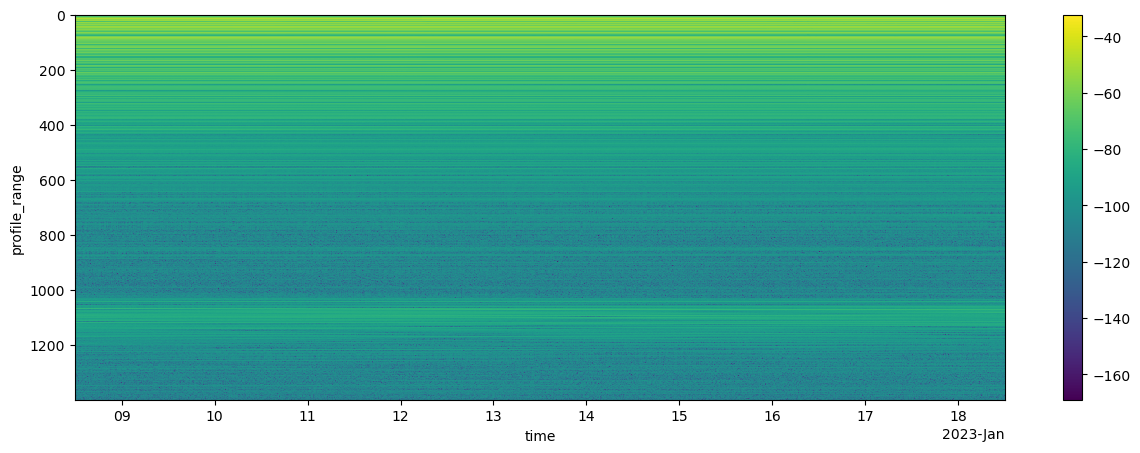

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(interp_profiles).plot(x='time')
ax.invert_yaxis()


In [9]:
b1 = interp_profiles.isel(time=range(0,len(interp_profiles)-1))
b2 = interp_profiles.isel(time=range(1,len(interp_profiles)))
dz, co, phi = xa.generate_range_diff(b1,b2,70,70,None,0,0.95)

In [10]:
four_hour = dz.range_diff.isel(time=range(0,32))

In [11]:
# Try this as a function over depth (histogram cant really be done here)

In [12]:
four_hour_mean = four_hour.mean(dim='time')
four_hour_std = four_hour.std(dim='time')
four_hour_error = four_hour_std/np.sqrt(len(four_hour.time))

Text(0, 0.5, 'standard error [m]')

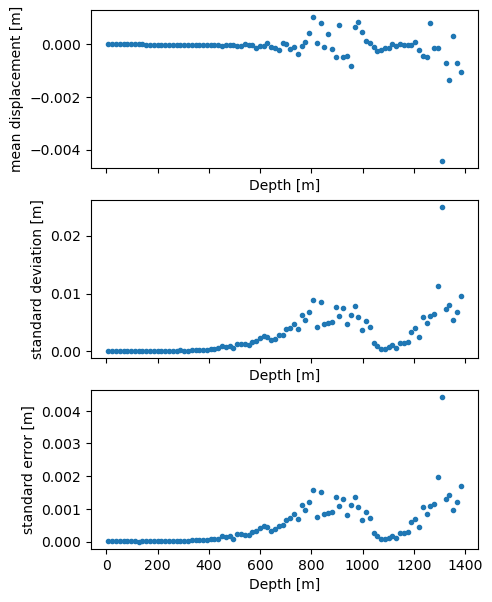

In [13]:
fig, axs = plt.subplots(figsize=(5,7),nrows = 3,sharex=True)
four_hour_mean.plot(ax=axs[0],linestyle='None',marker='.')
axs[0].set_ylabel('mean displacement [m]')
four_hour_std.plot(ax=axs[1],linestyle='None',marker='.')
axs[1].set_ylabel('standard deviation [m]')
four_hour_error.plot(ax=axs[2],linestyle='None',marker='.')
axs[2].set_ylabel('standard error [m]')

In [14]:
# over 5 days 
five_day_4_hour_chunks = dz.coarsen(time=32).mean()

Text(0.5, 0, 'Range difference [m]')

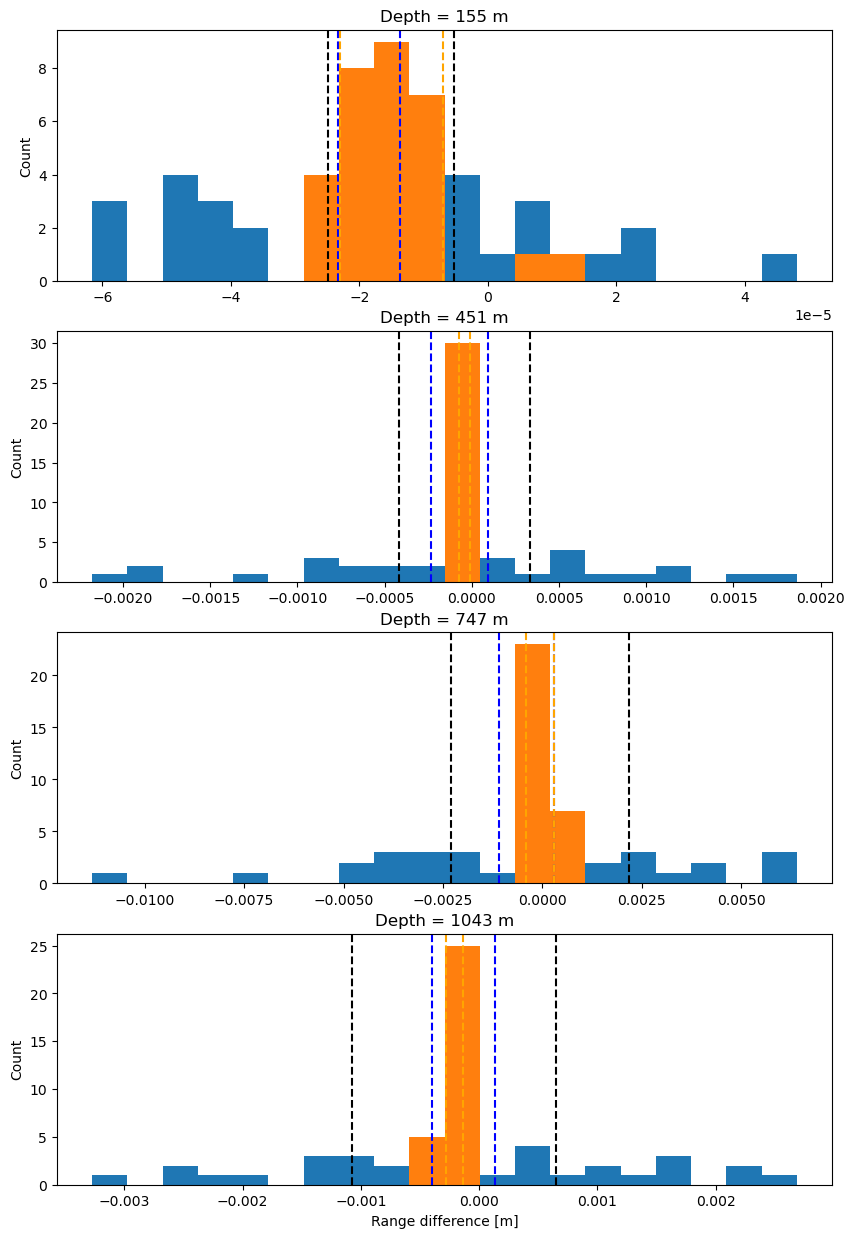

In [17]:
fig, axs = plt.subplots(figsize=(10,15),nrows = 4)#,sharex=True)
depth_indices = [10,30,50,70]
for i in range(4):
    at_depth = five_day_4_hour_chunks.isel(profile_range=depth_indices[i]) 
    minmax = (min(four_hour.isel(profile_range=depth_indices[i]).min(),at_depth.range_diff.min()).values,max(four_hour.isel(profile_range=depth_indices[i]).max(),at_depth.range_diff.max()).values)
              
    four_hour.isel(profile_range=depth_indices[i]).plot.hist(ax=axs[i],bins=20,range=minmax)    
    axs[i].axvline(four_hour_mean.isel(profile_range=depth_indices[i]) +four_hour_error.isel(profile_range=depth_indices[i]),color='blue',linestyle='--')
    axs[i].axvline(four_hour_mean.isel(profile_range=depth_indices[i]) -four_hour_error.isel(profile_range=depth_indices[i]),color='blue',linestyle='--')
    
    depth = at_depth.profile_range.values
    at_depth.range_diff.plot.hist(ax=axs[i],bins=20,range=minmax)
    mean = at_depth.range_diff.mean().values
    stddev = at_depth.range_diff.std().values
    axs[i].axvline(mean+stddev,color='orange',linestyle='--')
    axs[i].axvline(mean-stddev,color='orange',linestyle='--')
    
    processing_error = at_depth.err.mean().values
    axs[i].axvline(mean+processing_error,color='k',linestyle='--')
    axs[i].axvline(mean-processing_error,color='k',linestyle='--')
    axs[i].set_title(f'Depth = {int(depth)} m')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Count')
    
axs[-1].set_xlabel('Range difference [m]')

In [14]:
stddev

array(0.0001256)

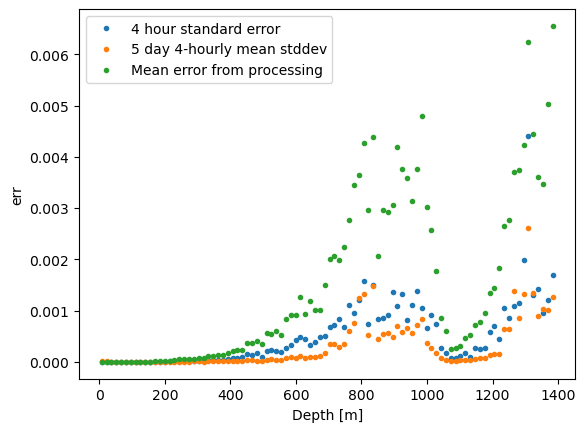

In [19]:
# Values on same plot
four_hour_error.plot(linestyle='None',marker='.',label='4 hour standard error')
five_day_4_hour_chunks.range_diff.std(dim='time').plot(linestyle='None',marker='.',label='5 day 4-hourly mean stddev')
dz.err.mean(dim='time').plot(linestyle='None',marker='.',label='Mean error from processing')
plt.legend()
#plt.xlim([0,400])
#plt.ylim([0,2e-4])

Pick some depths, and make histograms for those selected depths. 100, 200 300 meters, plot histograms for those. Do it for the 16 points from the 4 hours. Then do it with the mean values from the 5 day period. 

Also, try doing these with velocity estimates and normalize by time

What happens when there is a larger lag?

In [20]:
b1 = interp_profiles.isel(time=range(0,len(interp_profiles)-96))
b2 = interp_profiles.isel(time=range(96,len(interp_profiles)))
dz, co, phi = xa.generate_range_diff(b1,b2,70,70,None,0,0.95)

In [21]:
four_hour = dz.range_diff.isel(time=range(0,32))
four_hour_mean = four_hour.mean(dim='time')
four_hour_std = four_hour.std(dim='time')
four_hour_error = four_hour_std/np.sqrt(len(four_hour.time))

Text(0, 0.5, 'standard error [m]')

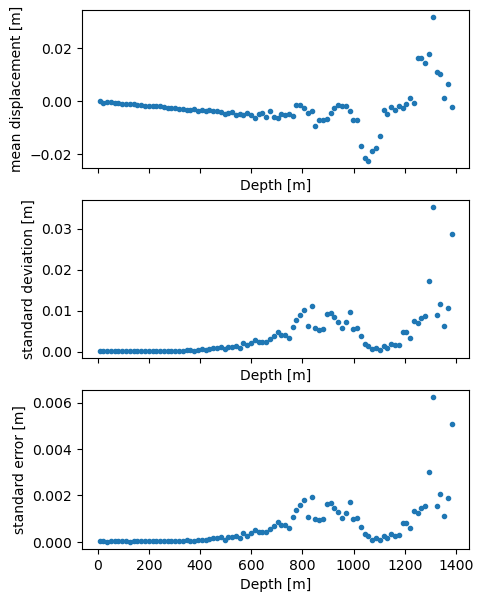

In [22]:
fig, axs = plt.subplots(figsize=(5,7),nrows = 3,sharex=True)
four_hour_mean.plot(ax=axs[0],linestyle='None',marker='.')
axs[0].set_ylabel('mean displacement [m]')
four_hour_std.plot(ax=axs[1],linestyle='None',marker='.')
axs[1].set_ylabel('standard deviation [m]')
four_hour_error.plot(ax=axs[2],linestyle='None',marker='.')
axs[2].set_ylabel('standard error [m]')

In [23]:
five_day_4_hour_chunks = dz.coarsen(time=32,boundary='pad').mean()

Text(0.5, 0, 'Range difference [m]')

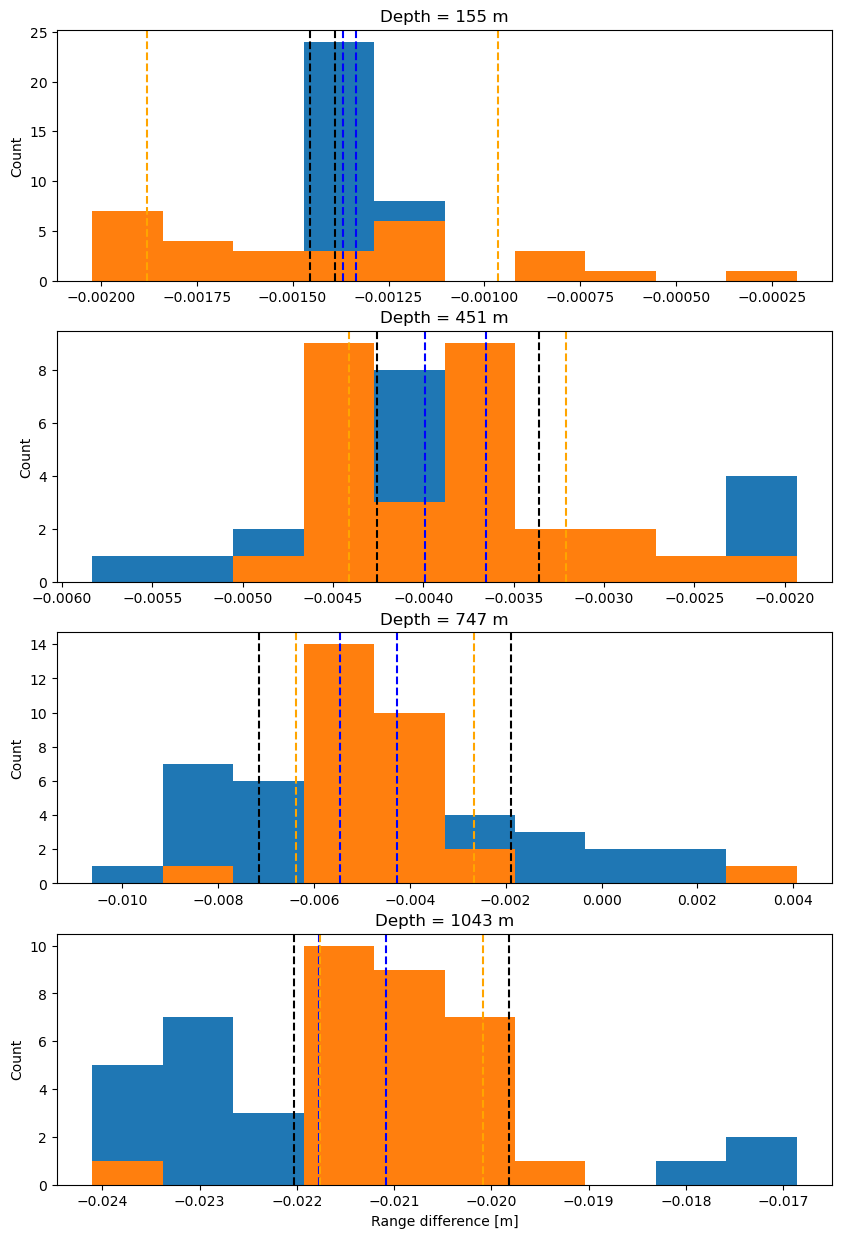

In [27]:
fig, axs = plt.subplots(figsize=(10,15),nrows = 4)#,sharex=True)
depth_indices = [10,30,50,70]
for i in range(4):
    at_depth = five_day_4_hour_chunks.isel(profile_range=depth_indices[i]) 
    minmax = (min(four_hour.isel(profile_range=depth_indices[i]).min(),at_depth.range_diff.min()).values,max(four_hour.isel(profile_range=depth_indices[i]).max(),at_depth.range_diff.max()).values)
              
    four_hour.isel(profile_range=depth_indices[i]).plot.hist(ax=axs[i],bins=10,range=minmax)    
    axs[i].axvline(four_hour_mean.isel(profile_range=depth_indices[i]) +four_hour_error.isel(profile_range=depth_indices[i]),color='blue',linestyle='--')
    axs[i].axvline(four_hour_mean.isel(profile_range=depth_indices[i]) -four_hour_error.isel(profile_range=depth_indices[i]),color='blue',linestyle='--')
    
    depth = at_depth.profile_range.values
    at_depth.range_diff.plot.hist(ax=axs[i],bins=10,range=minmax)
    mean = at_depth.range_diff.mean().values
    stddev = at_depth.range_diff.std().values
    axs[i].axvline(mean+stddev,color='orange',linestyle='--')
    axs[i].axvline(mean-stddev,color='orange',linestyle='--')
    
    processing_error = at_depth.err.mean().values
    axs[i].axvline(mean+processing_error,color='k',linestyle='--')
    axs[i].axvline(mean-processing_error,color='k',linestyle='--')
    axs[i].set_title(f'Depth = {int(depth)} m')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Count')
    
axs[-1].set_xlabel('Range difference [m]')

(0.0, 0.002)

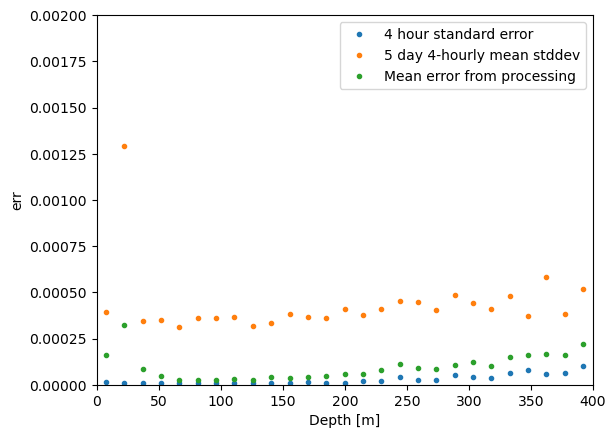

In [77]:
# Values on same plot
four_hour_error.plot(linestyle='None',marker='.',label='4 hour standard error')
five_day_4_hour_chunks.range_diff.std(dim='time').plot(linestyle='None',marker='.',label='5 day 4-hourly mean stddev')
dz.err.mean(dim='time').plot(linestyle='None',marker='.',label='Mean error from processing')
plt.legend()
plt.xlim([0,400])
plt.ylim([0,2e-3])

In [94]:
# Repeat with vertical velocities
b1 = interp_profiles.isel(time=range(0,len(interp_profiles)-1))
b2 = interp_profiles.isel(time=range(1,len(interp_profiles)))
dz, co, phi = xa.generate_range_diff(b1,b2,70,70,None,0,0.95)
vv = dz.range_diff / dz.time_diff * 31536000
vv_err = dz.err / dz.time_diff * 31536000

In [98]:
four_hour = vv.isel(time=range(0,16))
four_hour_mean = four_hour.mean(dim='time')
four_hour_std = four_hour.std(dim='time')
four_hour_error = four_hour_std/np.sqrt(len(four_hour.time))

Text(0, 0.5, 'standard error [m]')

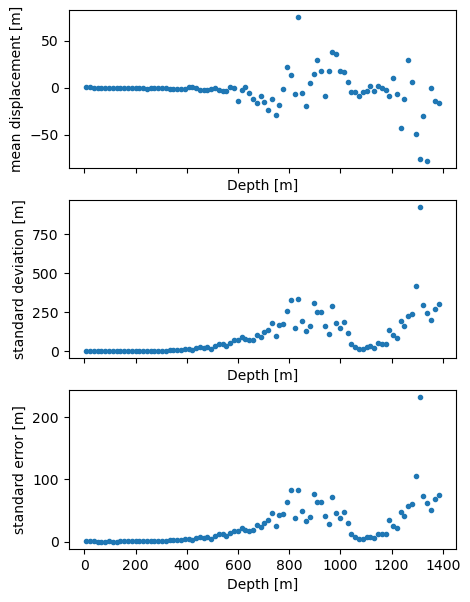

In [99]:
fig, axs = plt.subplots(figsize=(5,7),nrows = 3,sharex=True)
four_hour_mean.plot(ax=axs[0],linestyle='None',marker='.')
axs[0].set_ylabel('mean displacement [m]')
four_hour_std.plot(ax=axs[1],linestyle='None',marker='.')
axs[1].set_ylabel('standard deviation [m]')
four_hour_error.plot(ax=axs[2],linestyle='None',marker='.')
axs[2].set_ylabel('standard error [m]')

In [100]:
five_day_4_hour_chunks = vv.coarsen(time=16,boundary='pad').mean()

Text(0.5, 0, 'vertical velocity [m y$^{-1}$]')

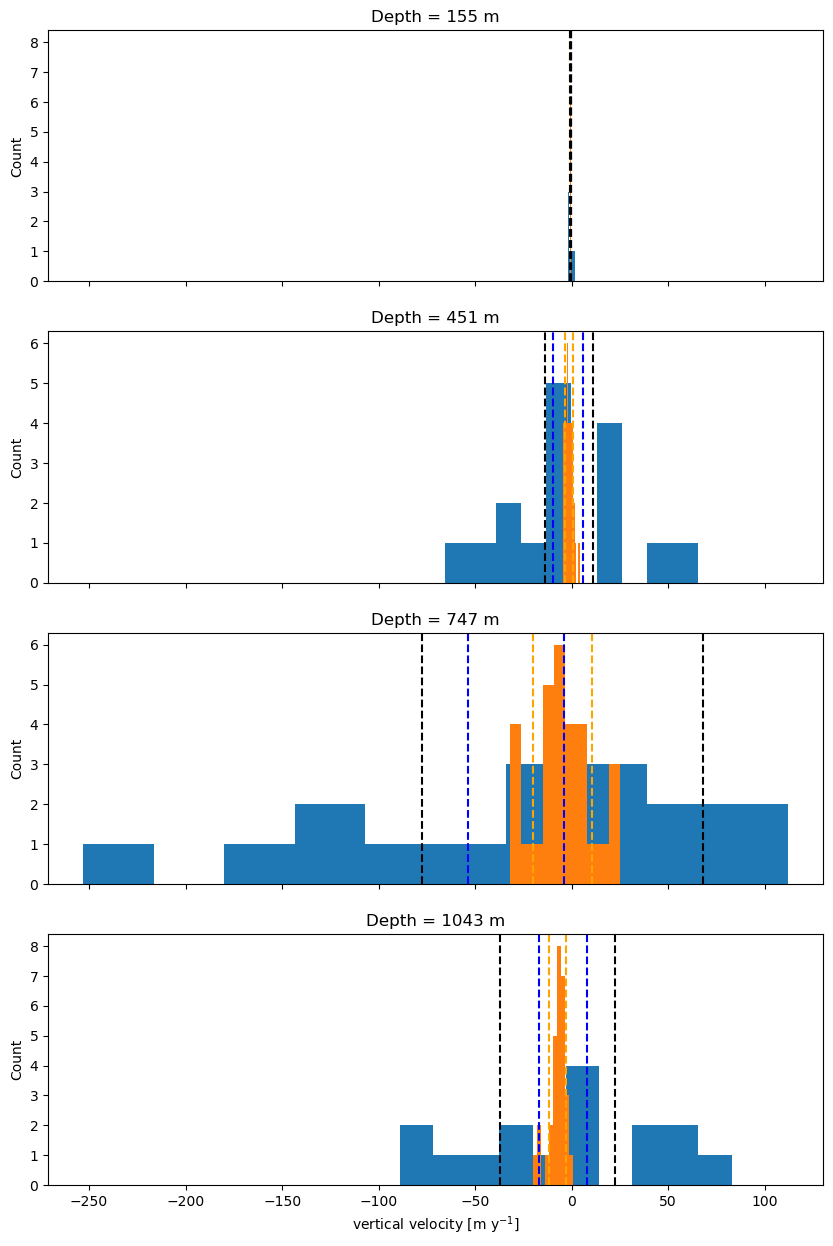

In [103]:
fig, axs = plt.subplots(figsize=(10,15),nrows = 4,sharex=True)
depth_indices = [10,30,50,70]
for i in range(4):
    four_hour.isel(profile_range=depth_indices[i]).plot.hist(ax=axs[i])    
    axs[i].axvline(four_hour_mean.isel(profile_range=depth_indices[i]) +four_hour_error.isel(profile_range=depth_indices[i]),color='blue',linestyle='--')
    axs[i].axvline(four_hour_mean.isel(profile_range=depth_indices[i]) -four_hour_error.isel(profile_range=depth_indices[i]),color='blue',linestyle='--')
    
    at_depth = five_day_4_hour_chunks.isel(profile_range=depth_indices[i]) 
    depth = at_depth.profile_range.values
    at_depth.plot.hist(ax=axs[i])
    mean = at_depth.mean().values
    stddev = at_depth.std().values
    axs[i].axvline(mean+stddev,color='orange',linestyle='--')
    axs[i].axvline(mean-stddev,color='orange',linestyle='--')
    
    processing_error = vv_err.isel(profile_range=depth_indices[i]).mean().values
    axs[i].axvline(mean+processing_error,color='k',linestyle='--')
    axs[i].axvline(mean-processing_error,color='k',linestyle='--')
    axs[i].set_title(f'Depth = {int(depth)} m')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Count')
    
axs[-1].set_xlabel('vertical velocity [m y$^{-1}$]')

In [104]:
# Repeat with vertical velocities 1 day estimate
b1 = interp_profiles.isel(time=range(0,len(interp_profiles)-96))
b2 = interp_profiles.isel(time=range(96,len(interp_profiles)))
dz, co, phi = xa.generate_range_diff(b1,b2,70,70,None,0,0.95)
vv = dz.range_diff / dz.time_diff * 31536000
vv_err = dz.err / dz.time_diff * 31536000

In [105]:
four_hour = vv.isel(time=range(0,16))
four_hour_mean = four_hour.mean(dim='time')
four_hour_std = four_hour.std(dim='time')
four_hour_error = four_hour_std/np.sqrt(len(four_hour.time))

Text(0, 0.5, 'standard error [m]')

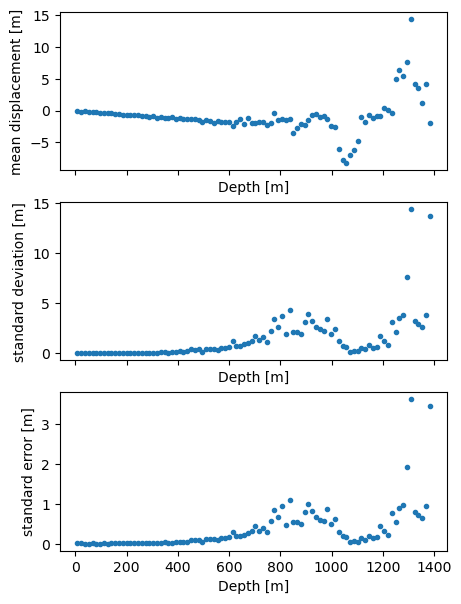

In [106]:
fig, axs = plt.subplots(figsize=(5,7),nrows = 3,sharex=True)
four_hour_mean.plot(ax=axs[0],linestyle='None',marker='.')
axs[0].set_ylabel('mean displacement [m]')
four_hour_std.plot(ax=axs[1],linestyle='None',marker='.')
axs[1].set_ylabel('standard deviation [m]')
four_hour_error.plot(ax=axs[2],linestyle='None',marker='.')
axs[2].set_ylabel('standard error [m]')

In [107]:
five_day_4_hour_chunks = vv.coarsen(time=16,boundary='pad').mean()

Text(0.5, 0, 'vertical velocity [m y$^{-1}$]')

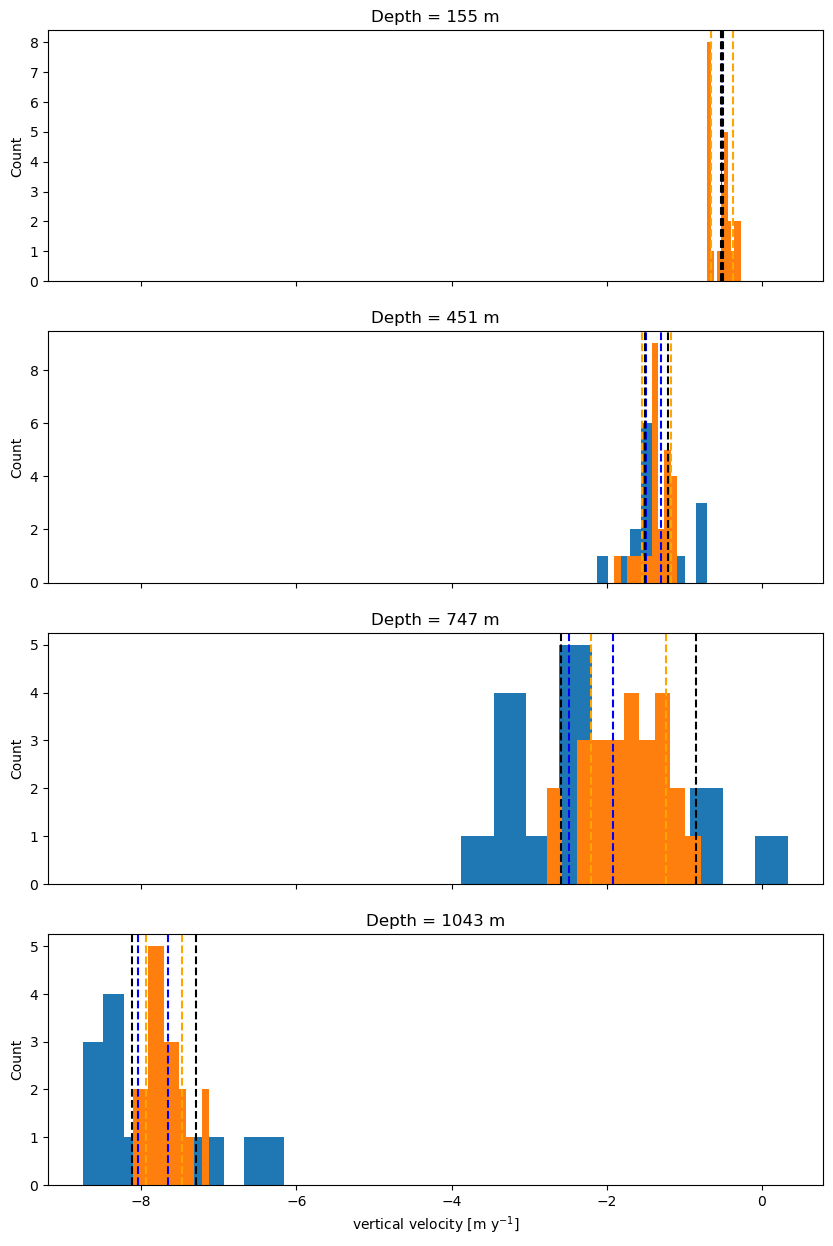

In [108]:
fig, axs = plt.subplots(figsize=(10,15),nrows = 4,sharex=True)
depth_indices = [10,30,50,70]
for i in range(4):
    four_hour.isel(profile_range=depth_indices[i]).plot.hist(ax=axs[i])    
    axs[i].axvline(four_hour_mean.isel(profile_range=depth_indices[i]) +four_hour_error.isel(profile_range=depth_indices[i]),color='blue',linestyle='--')
    axs[i].axvline(four_hour_mean.isel(profile_range=depth_indices[i]) -four_hour_error.isel(profile_range=depth_indices[i]),color='blue',linestyle='--')
    
    at_depth = five_day_4_hour_chunks.isel(profile_range=depth_indices[i]) 
    depth = at_depth.profile_range.values
    at_depth.plot.hist(ax=axs[i])
    mean = at_depth.mean().values
    stddev = at_depth.std().values
    axs[i].axvline(mean+stddev,color='orange',linestyle='--')
    axs[i].axvline(mean-stddev,color='orange',linestyle='--')
    
    processing_error = vv_err.isel(profile_range=depth_indices[i]).mean().values
    axs[i].axvline(mean+processing_error,color='k',linestyle='--')
    axs[i].axvline(mean-processing_error,color='k',linestyle='--')
    axs[i].set_title(f'Depth = {int(depth)} m')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Count')
    
axs[-1].set_xlabel('vertical velocity [m y$^{-1}$]')

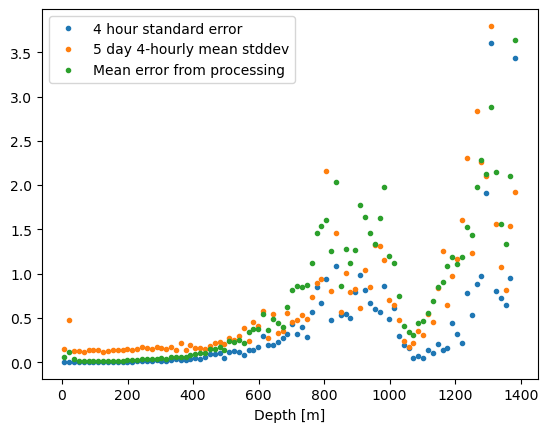

In [111]:
# Values on same plot
four_hour_error.plot(linestyle='None',marker='.',label='4 hour standard error')
five_day_4_hour_chunks.std(dim='time').plot(linestyle='None',marker='.',label='5 day 4-hourly mean stddev')
vv_err.coarsen(time=16,boundary='pad').mean().mean(dim='time').plot(linestyle='None',marker='.',label='Mean error from processing')
plt.legend()
#plt.xlim([0,400])
#plt.ylim([0,2e-3])

# Summer 

In [20]:
with open('../chirp_processing/A11_22S.pickle', 'rb') as handle:
    s22 = pickle.load(handle)

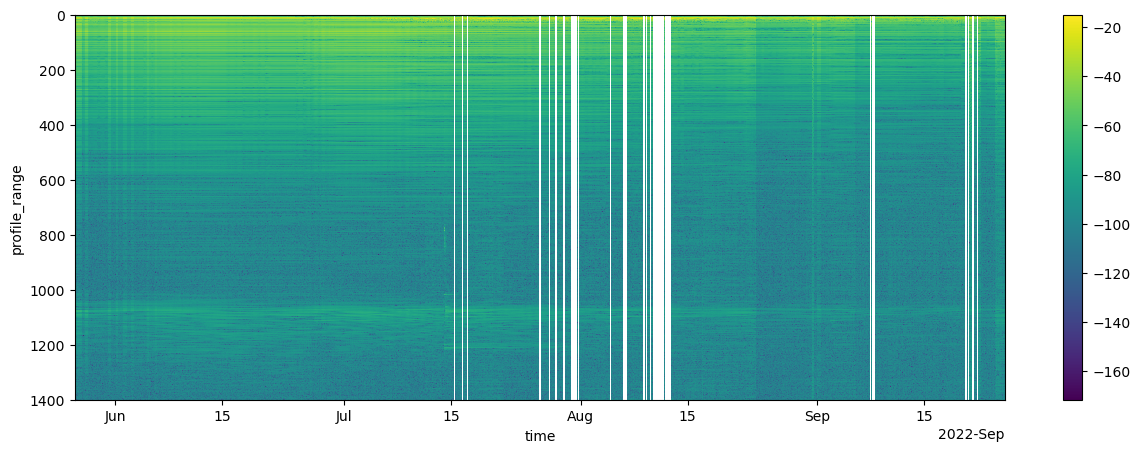

In [21]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(s22).plot(x='time')
ax.invert_yaxis()


In [23]:
time_to_interp = pd.date_range("2022-06-15 12:00", "2022-06-20 12:00", freq="15min")
interp_profiles = s22.interp(time=time_to_interp,method='linear')

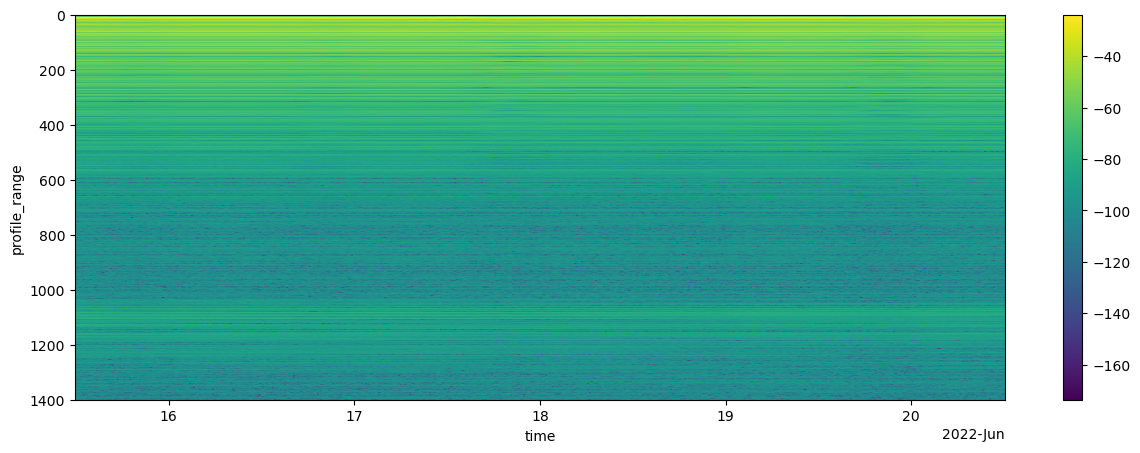

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(interp_profiles).plot(x='time')
ax.invert_yaxis()


In [25]:
b1 = interp_profiles.isel(time=range(0,len(interp_profiles)-1))
b2 = interp_profiles.isel(time=range(1,len(interp_profiles)))
dz, co, phi = xa.generate_range_diff(b1,b2,70,70,None,0,0.95)

In [26]:
four_hour = dz.range_diff.isel(time=range(0,16))
four_hour_mean = four_hour.mean(dim='time')
four_hour_std = four_hour.std(dim='time')
four_hour_error = four_hour_std/np.sqrt(len(four_hour.time))

Text(0, 0.5, 'standard error [m]')

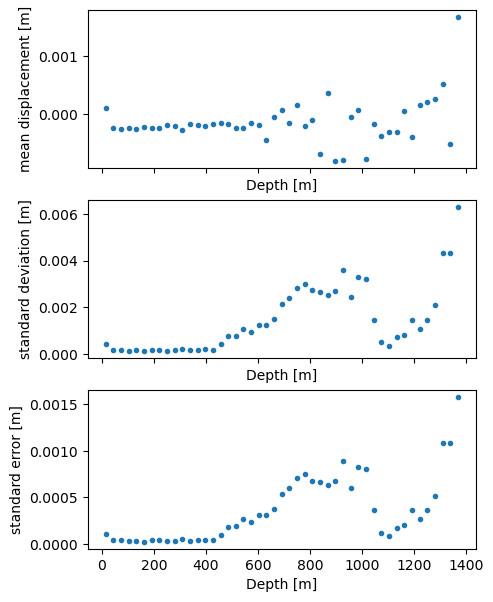

In [27]:
fig, axs = plt.subplots(figsize=(5,7),nrows = 3,sharex=True)
four_hour_mean.plot(ax=axs[0],linestyle='None',marker='.')
axs[0].set_ylabel('mean displacement [m]')
four_hour_std.plot(ax=axs[1],linestyle='None',marker='.')
axs[1].set_ylabel('standard deviation [m]')
four_hour_error.plot(ax=axs[2],linestyle='None',marker='.')
axs[2].set_ylabel('standard error [m]')

In [28]:
five_day_4_hour_chunks = dz.coarsen(time=16,boundary='pad').mean()

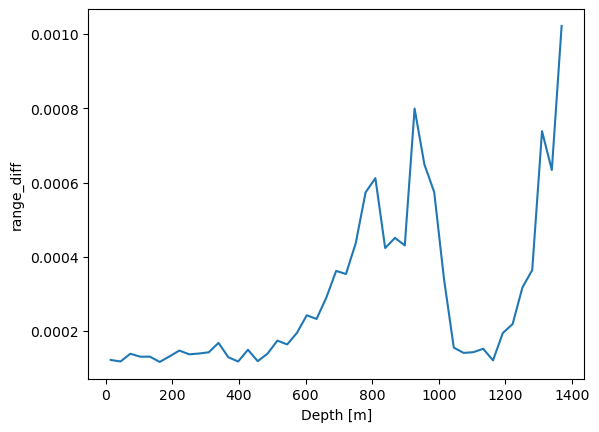

In [29]:
five_day_4_hour_chunks.range_diff.std(dim='time').plot()

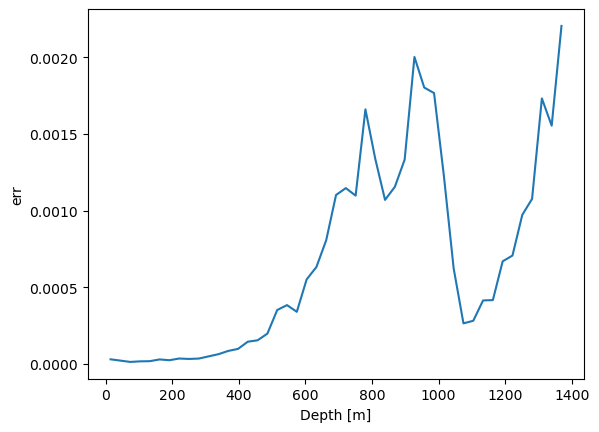

In [30]:
dz.err.mean(dim='time').plot()

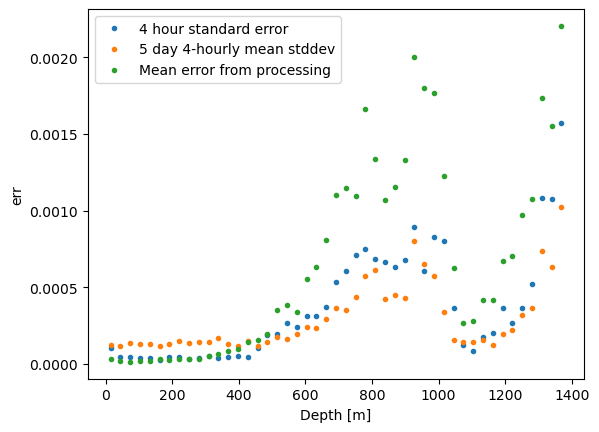

In [31]:
# Values on same plot
four_hour_error.plot(linestyle='None',marker='.',label='4 hour standard error')
five_day_4_hour_chunks.range_diff.std(dim='time').plot(linestyle='None',marker='.',label='5 day 4-hourly mean stddev')
dz.err.mean(dim='time').plot(linestyle='None',marker='.',label='Mean error from processing')
plt.legend()

Now with greater lag

In [32]:
b1 = interp_profiles.isel(time=range(0,len(interp_profiles)-96))
b2 = interp_profiles.isel(time=range(96,len(interp_profiles)))
dz, co, phi = xa.generate_range_diff(b1,b2,70,70,None,0,0.95)

In [33]:
four_hour = dz.range_diff.isel(time=range(0,16))
four_hour_mean = four_hour.mean(dim='time')
four_hour_std = four_hour.std(dim='time')
four_hour_error = four_hour_std/np.sqrt(len(four_hour.time))

Text(0, 0.5, 'standard error [m]')

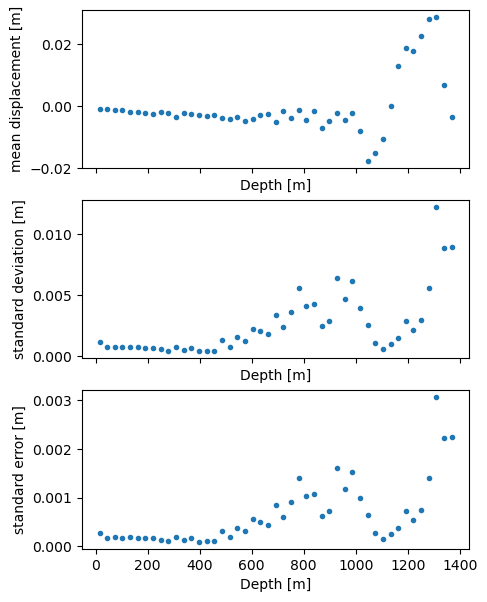

In [34]:
fig, axs = plt.subplots(figsize=(5,7),nrows = 3,sharex=True)
four_hour_mean.plot(ax=axs[0],linestyle='None',marker='.')
axs[0].set_ylabel('mean displacement [m]')
four_hour_std.plot(ax=axs[1],linestyle='None',marker='.')
axs[1].set_ylabel('standard deviation [m]')
four_hour_error.plot(ax=axs[2],linestyle='None',marker='.')
axs[2].set_ylabel('standard error [m]')

In [35]:
five_day_4_hour_chunks = dz.coarsen(time=16,boundary='pad').mean()

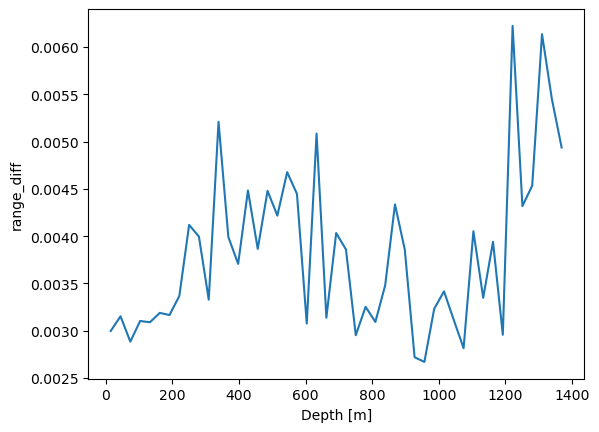

In [36]:
five_day_4_hour_chunks.range_diff.std(dim='time').plot()

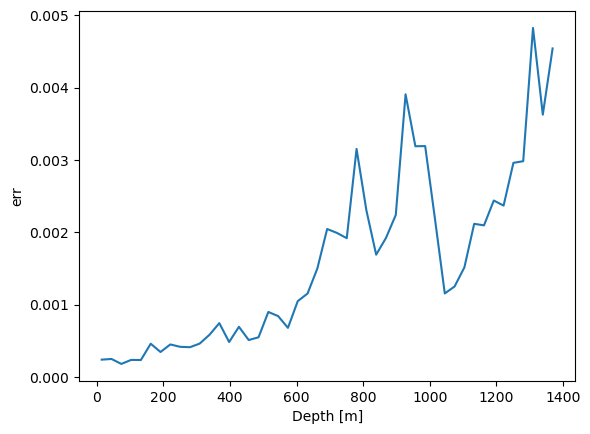

In [37]:
dz.err.mean(dim='time').plot()

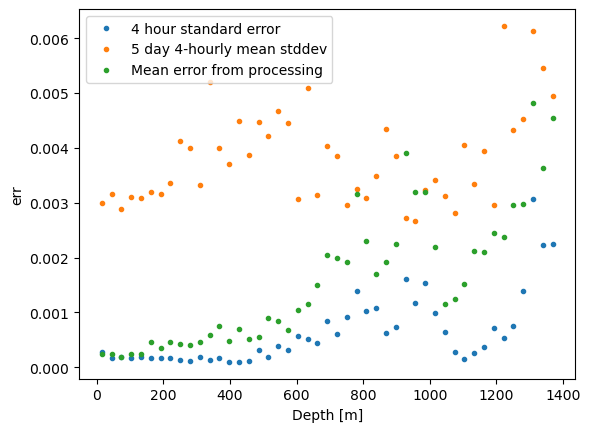

In [38]:
# Values on same plot
four_hour_error.plot(linestyle='None',marker='.',label='4 hour standard error')
five_day_4_hour_chunks.range_diff.std(dim='time').plot(linestyle='None',marker='.',label='5 day 4-hourly mean stddev')
dz.err.mean(dim='time').plot(linestyle='None',marker='.',label='Mean error from processing')
plt.legend()